In [1]:
using Pkg;
Pkg.activate("../");

using PyCall;
pygui(:tk);

  Activating project at `D:\GitHub\book-dp1\julia_version`


In [2]:
"""
Two period job search in the IID case.
"""

using Distributions

"Creates an instance of the job search model, stored as a NamedTuple."
function create_job_search_model(;
        n=50,        # wage grid size
        w_min=10.0,  # lowest wage
        w_max=60.0,  # highest wage
        a=200,       # wage distribution parameter
        b=100,       # wage distribution parameter
        β=0.96,      # discount factor
        c=10.0       # unemployment compensation
    )
    w_vals = collect(LinRange(w_min, w_max, n+1))
    ϕ = pdf(BetaBinomial(n, a, b))
    return (; n, w_vals, ϕ, β, c)
end

" Computes lifetime value at t=1 given current wage w_1 = w. "
function v_1(w, model)
    (; n, w_vals, ϕ, β, c) = model
    h_1 = c + β * max.(c, w_vals)'ϕ
    return max(w + β * w, h_1)
end

" Computes reservation wage at t=1. "
function res_wage(model)
    (; n, w_vals, ϕ, β, c) = model
    h_1 = c + β * max.(c, w_vals)'ϕ
    return h_1 / (1 + β)
end


# == Plots == #

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering

default_model = create_job_search_model()

" Plot the distribution of wages. "
function fig_dist(model=default_model, fs=14)
    fig, ax = plt.subplots()
    ax.plot(model.w_vals, model.ϕ, "-o", alpha=0.5, label="wage distribution")
    ax.legend(loc="upper left", fontsize=fs)
end


" Plot two-period value function and res wage. "
function fig_v1(model=default_model; savefig=false, 
                  figname="../figures/iid_job_search_0.pdf", fs=18)

    (; n, w_vals, ϕ, β, c) = model

    v = [v_1(w, model) for w in model.w_vals]
    w_star = res_wage(model)
    continuation_val = c + β * max.(c, w_vals)'ϕ
    min_w, max_w = minimum(w_vals), maximum(w_vals)

    fig, ax = plt.subplots(figsize=(9, 5.5))
    ax.set_ylim(0, 120)
    ax.set_xlim(min_w, max_w)
    ax.vlines((w_star,), (0,), (continuation_val,), lw=0.5)
    ax.set_yticks((0, 50, 100))
    ax.set_yticklabels((0, 50, 100), fontsize=12)
    ax.set_xticks((min_w, w_star, max_w))
    ax.set_xticklabels((min_w, L"$w^*_1$", max_w), fontsize=12)
    ax.plot(w_vals, w_vals + β * w_vals, "-", alpha=0.8, lw=3, 
            label=L"$w_1 + \beta w_1$")
    ax.plot(w_vals, fill(continuation_val, n+1), lw=3, alpha=0.8, 
            label=L"$c + \beta \sum_{w'} \max\{c, w'\} \varphi(w')$" )
    ax.plot(w_vals, v, "k--", ms=2, alpha=1.0, lw=2, label=L"$v_1(w_1)$")
    ax.legend(frameon=false, fontsize=fs, loc="upper left")
    if savefig
        fig.savefig(figname)
    end
end



fig_v1

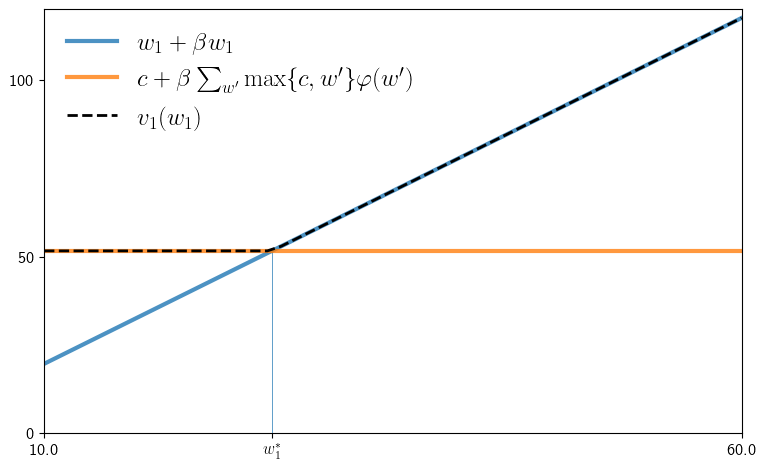

In [3]:
fig_v1(savefig=true)

In [4]:
using LinearAlgebra                         
ρ(A) = maximum(abs(λ) for λ in eigvals(A))  # Spectral radius
A = [0.4 0.1;                               # Test with arbitrary A
     0.7 0.2]
print(ρ(A))

0.5828427124746189

In [5]:
using LinearAlgebra

# Primitives
A = [0.4 0.1;
     0.7 0.2]

# Method one: direct inverse
B_inverse = inv(I - A)

# Method two: power series
function power_series(A)
    B_sum = zeros((2, 2))
    A_power = I
    for k in 1:50
        B_sum += A_power
        A_power = A_power * A
    end
    return B_sum
end

# Print maximal error
print(maximum(abs.(B_inverse - power_series(A))))

5.6210591736771676e-12

In [6]:
"""
Computes an approximate fixed point of a given operator T 
via successive approximation.

"""
function successive_approx(T,                  # operator (callable)
                           u_0;                # initial condition
                           tolerance=1e-6,     # error tolerance
                           max_iter=10_000,    # max iteration bound
                           print_step=25)      # print at multiples
    u = u_0
    error = Inf
    k = 1

    while (error > tolerance) & (k <= max_iter)
        
        u_new = T(u)
        error = maximum(abs.(u_new - u))

        if k % print_step == 0
            println("Completed iteration $k with error $error.")
        end

        u = u_new
        k += 1
    end

    if error <= tolerance
        println("Terminated successfully in $k iterations.")
    else
        println("Warning: hit iteration bound.")
    end

    return u
end

successive_approx

In [7]:
include("s_approx.jl")
using LinearAlgebra

# Compute the fixed point of Tu = Au + b via linear algebra
A, b = [0.4 0.1; 0.7 0.2], [1.0; 2.0]
u_star = (I - A) \ b  # compute (I - A)^{-1} * b

# Compute the fixed point via successive approximation
T(u) = A * u + b
u_0 = [1.0; 1.0]
u_star_approx = successive_approx(T, u_0)

# Test for approximate equality (prints "true")
print(isapprox(u_star, u_star_approx, rtol=1e-5))


Completed iteration 25 with error 2.911659384707832e-6.
Terminated successfully in 28 iterations.


true

Completed iteration 25 with error 2.911659384707832e-6.
Terminated successfully in 28 iterations.
true

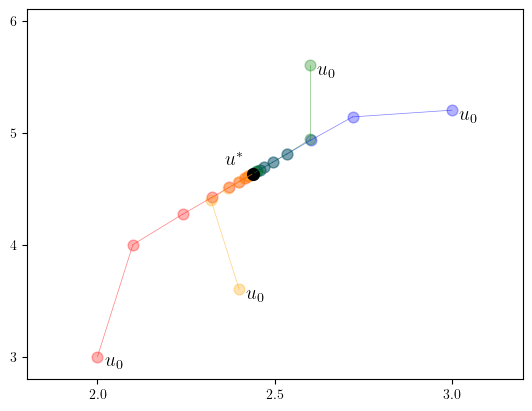

In [8]:
include("linear_iter.jl")
using PyPlot

PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering

fig, ax = plt.subplots()

e = 0.02

marker_size = 60
fs=14

colors = ("red", "blue", "orange", "green")
u_0_vecs = ([2.0; 3.0], [3.0; 5.2], [2.4; 3.6], [2.6, 5.6])
iter_range = 8

for (u_0, color) in zip(u_0_vecs, colors)
    u = u_0
    s, t = u
    ax.text(s+e, t-4e, L"u_0", fontsize=fs)

    for i in 1:iter_range
        s, t = u
        ax.scatter((s,), (t,), c=color, alpha=0.3, s=marker_size)
        u_new = T(u)
        s_new, t_new = u_new
        ax.plot((s, s_new), (t, t_new), lw=0.5, alpha=0.5, c=color)
        u = u_new
    end
end

s_star, t_star = u_star
ax.scatter((s_star,), (t_star,), c="k", s=marker_size * 1.2)
ax.text(s_star-4e, t_star+4e, L"u^*", fontsize=fs)

ax.set_xticks((2.0, 2.5, 3.0))
ax.set_yticks((3.0, 4.0, 5.0, 6.0))
ax.set_xlim(1.8, 3.2)
ax.set_ylim(2.8, 6.1)

fig.savefig("../figures/linear_iter_fig_1.pdf")


In [9]:
"""
VFI approach to job search in the infinite-horizon IID case.

"""

include("two_period_job_search.jl")
include("s_approx.jl")

" The Bellman operator. "
function T(v, model)
    (; n, w_vals, ϕ, β, c) = model
    return [max(w / (1 - β), c + β * v'ϕ) for w in w_vals]
end

" Get a v-greedy policy. "
function get_greedy(v, model)
    (; n, w_vals, ϕ, β, c) = model
    σ = w_vals ./ (1 - β) .>= c .+ β * v'ϕ  # Boolean policy vector
    return σ
end
        
" Solve the infinite-horizon IID job search model by VFI. "
function vfi(model=default_model) 
    (; n, w_vals, ϕ, β, c) = model
    v_init = zero(model.w_vals)  
    v_star = successive_approx(v -> T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star
end
    

# == Plots == #

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering

# A model with default parameters
default_model = create_job_search_model()


" Plot a sequence of approximations. "
function fig_vseq(model=default_model; 
                    k=3, 
                    savefig=false, 
                    figname="../figures/iid_job_search_1.pdf",
                    fs=16)

    v = zero(model.w_vals)  
    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i in 1:k
        ax.plot(model.w_vals, v, lw=3, alpha=0.6, label="iterate $i")
        v = T(v, model)
    end

    for i in 1:1000
        v = T(v, model)
    end
    ax.plot(model.w_vals, v, "k-", lw=3.0, label="iterate 1000", alpha=0.7)

    #ax.set_ylim((0, 140))
    ax.set_xlabel("wage offer", fontsize=fs)
    ax.set_ylabel("lifetime value", fontsize=fs)

    ax.legend(fontsize=fs, frameon=false)

    if savefig
        fig.savefig(figname)
    end
end


" Plot the fixed point. "
function fig_vstar(model=default_model; 
                   savefig=false, fs=18,
                   figname="../figures/iid_job_search_3.pdf")

    (; n, w_vals, ϕ, β, c) = model
    v_star, σ_star = vfi(model)

    fig, ax = plt.subplots(figsize=(9, 5.5))
    ax.plot(w_vals, v_star, "k-", lw=1.5, label="value function")
    cont_val = c + β * v_star'ϕ
    ax.plot(w_vals, fill(cont_val, n+1), 
            "--", 
            lw=5,
            alpha=0.5,
            label="continuation value")

    ax.plot(w_vals,
            w_vals / (1 - β),
            "--",
            lw=5,
            alpha=0.5,
            label=L"w/(1 - \beta)")

    #ax.set_ylim(0, v_star.max())
    ax.legend(frameon=false, fontsize=fs, loc="lower right")

    if savefig
        fig.savefig(figname)
    end
end




fig_vstar

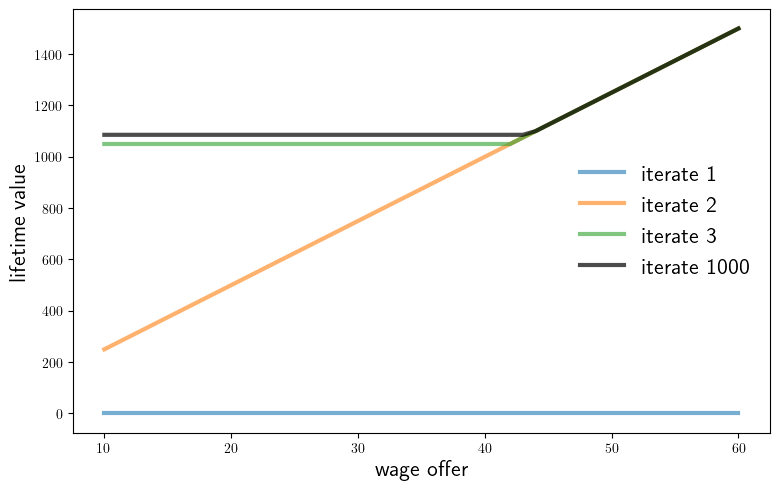

In [10]:
fig_vseq(savefig=true)

Completed iteration 25 with error 2.2046856429369655e-6.
Terminated successfully in 28 iterations.

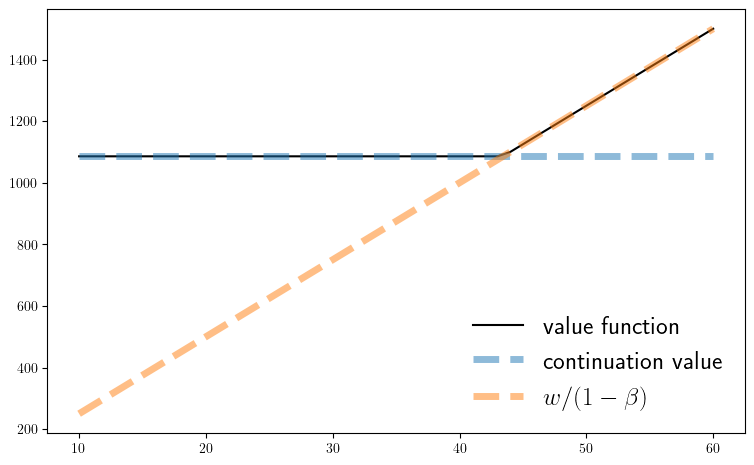

In [11]:
fig_vstar(savefig=true)